# Pleasant Lake Example

* **[View the configuration file(s)](https://aleaf.github.io/modflow-setup/config-file-gallery.html#pleasant-lake-test-case)** 
* **[Run this example](https://mybinder.org/v2/gh/aleaf/modflow-setup/develop?urlpath=lab/tree/examples)  on  [Binder](https://mybinder.org/)**

#### Model details
* MODFLOW-6 model with local grid refinement (LGR)
* LGR parent model is itself a Telescopic Mesh Refinment (TMR) inset from a MODFLOW-NWT model
* Layer 1 in TMR parent model is subdivided evenly into two layers in LGR model (``botm: from_parent: 0: -0.5``). Other layers mapped explicitly between TMR parent and LGR model.
* starting heads from LGR parent model resampled from binary output from the TMR parent
* rch, npf, sto, and wel input copied from parent model
* SFR package constructed from an NHDPlus v2 dataset (path to NHDPlus files in the same structure as the `downloads from the NHDPlus website`_)
* head observations from csv files with different column names
* LGR inset extent based on a buffer distance around a feature of interest
* LGR inset dis, ic, npf, sto and rch packages copied from LGR parent
* WEL package created from custom format
* Lake package created from polygon features, bathymetry raster, stage-area-volume file and climate data from `PRISM`_.
* Lake package observations set up automatically (output file for each lake)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from mfsetup import MF6model
from mfsetup.discretization import cellids_to_kij
from gisutils import df2shp
import mfexport

In [2]:
m = MF6model.setup_from_yaml('pleasant_lgr_parent.yml')

loading configuration file pleasant_lgr_parent.yml...

Setting up plsnt_lgr_parent model from data in None


arguments to MFSimulation:
sim_name: pleasant_lgr
version: mf6
exe_name: mf6
sim_ws: /home/travis/build/aleaf/modflow-setup/examples/pleasant_lgr

arguments to ModflowGwf:
modelname: plsnt_lgr_parent
version: mf6
simulation: sim_name = pleasant_lgr
sim_path = /home/travis/build/aleaf/modflow-setup/examples/pleasant_lgr
exe_name = mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = pleasant_lgr



list: plsnt_lgr_parent.list
print_input: True
print_flows: False
save_flows: True
newtonoptions: ['under_relaxation']
loading parent model /home/travis/build/aleaf/modflow-setup/examples/data/pleasant/pleasant.nam...

arguments to Modflow.load:
model_ws: /home/travis/build/aleaf/modflow-setup/examples/data/pleasant
version: mfnwt
load_only: [rch ... bas

In [3]:
m

plsnt_lgr_parent model:
5 layer(s), 25 row(s), 25 column(s), 13 stress period(s)
Parent model: /home/travis/build/aleaf/modflow-setup/examples/data/pleasant/pleasant
CRS: epsg:3070
(epsg: 3070)
Bounds: (552800.0, 557800.0, 388200.0, 393200.0)
Grid spacing: 200.00 meters
Packages: dis ic npf sto rcha oc sfr_0 wel_0 obs_0 chd_0

In [4]:
m.cfg.keys()

dict_keys(['start_version', 'simulation', 'model', 'parent', 'intermediate_data', 'postprocessing', 'setup_grid', 'dis', 'tdis', 'ic', 'npf', 'sto', 'rch', 'sfr', 'high_k_lakes', 'lak', 'mvr', 'riv', 'wel', 'chd', 'oc', 'obs', 'ims', 'filename', 'ghb', 'maw', 'external_files', 'grid', 'perimeter_boundary'])

In [5]:
m.cfg['dis']

defaultdict(dict,
            {'options': {'length_units': 'meters'},
             'dimensions': {'nlay': 5},
             'griddata': {'top': [{'filename': './external/plsnt_lgr_parent_top.dat'}],
              'botm': [{'filename': './external/plsnt_lgr_parent_botm0.dat'},
               {'filename': './external/plsnt_lgr_parent_botm1.dat'},
               {'filename': './external/plsnt_lgr_parent_botm2.dat'},
               {'filename': './external/plsnt_lgr_parent_botm3.dat'},
               {'filename': './external/plsnt_lgr_parent_botm4.dat'}],
              'idomain': [{'filename': './external/plsnt_lgr_parent_idomain0.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain1.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain2.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain3.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain4.dat'}]},
             'top_filename_fmt': 'top.dat',
             'botm_fi

In [6]:
m.inset

{'plsnt_lgr_inset': plsnt_lgr_inset model:
 5 layer(s), 70 row(s), 80 column(s), 13 stress period(s)
 Parent model: ./plsnt_lgr_parent
 CRS: epsg:3070
 (epsg: 3070)
 Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
 Grid spacing: 40.00 meters
 Packages: dis ic npf sto rcha oc sfr_0 lak_0 obs_0 wel_0 obs_1}

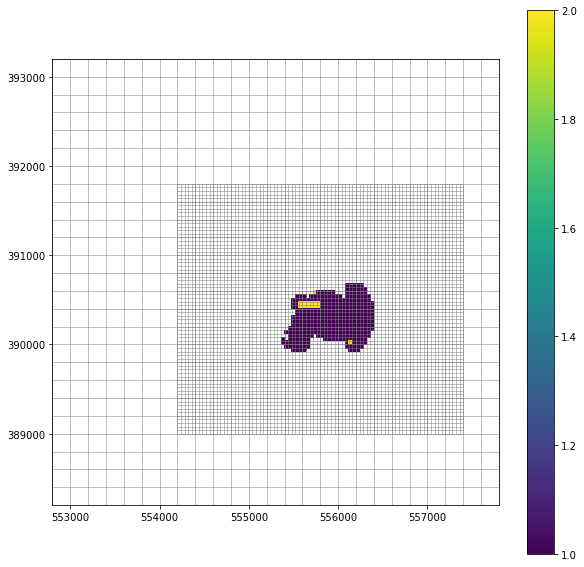

In [7]:
inset = m.inset['plsnt_lgr_inset']

l, r, b, t = m.modelgrid.extent
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

vconn = inset.lak.connectiondata.array[inset.lak.connectiondata.array['claktype'] == 'vertical']
k, i, j = cellids_to_kij(vconn['cellid'])
lakeconnections = np.zeros((inset.nrow, inset.ncol))
lakeconnections[i, j] = np.array(k)
lakeconnections = np.ma.masked_array(lakeconnections, mask=lakeconnections == 0)
qmi = inset_mv.plot_array(lakeconnections)

#inset_mv.plot_bc('LAK', color='navy')
#parent_mv.plot_bc('WEL_0', color='red')

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
plt.colorbar(qmi)

In [8]:
m.write_input()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing mvr package pleasant_lgr.mvr...
  writing package pleasant_lgr.gwfgwf...
  writing model plsnt_lgr_parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writing package oc...
    writing package sfr_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package obs_0...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 235 based on size of stress_period_data
  writing model plsnt_lgr_inset...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writing package oc...
    writing

In [9]:
m.simulation.run_simulation()

FloPy is using the following  executable to run the model: /home/travis/build/aleaf/modflow-setup/bin/linux/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

   MODFLOW 6 compiled Dec 13 2019 11:34:14 with IFORT compiler (ver. 18.0.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refe

(True, [])

In [10]:
os.getcwd()

'/home/travis/build/aleaf/modflow-setup/examples/pleasant_lgr'

In [11]:
tmr_parent_headsobj = bf.HeadFile('../data/pleasant/pleasant.hds')
lgr_parent_headsobj = bf.HeadFile('plsnt_lgr_parent.hds')
lgr_inset_headsobj = bf.HeadFile('plsnt_lgr_inset.hds')

tmr_parent_hds = tmr_parent_headsobj.get_data(kstpkper=(4, 12))
lgr_parent_hds = lgr_parent_headsobj.get_data(kstpkper=(0, 12))
lgr_inset_hds = lgr_inset_headsobj.get_data(kstpkper=(0, 12))

lgr_parent_hds = np.ma.masked_array(lgr_parent_hds, mask=lgr_parent_hds == 1e30)
lgr_inset_hds = np.ma.masked_array(lgr_inset_hds, mask=lgr_inset_hds == 1e30)

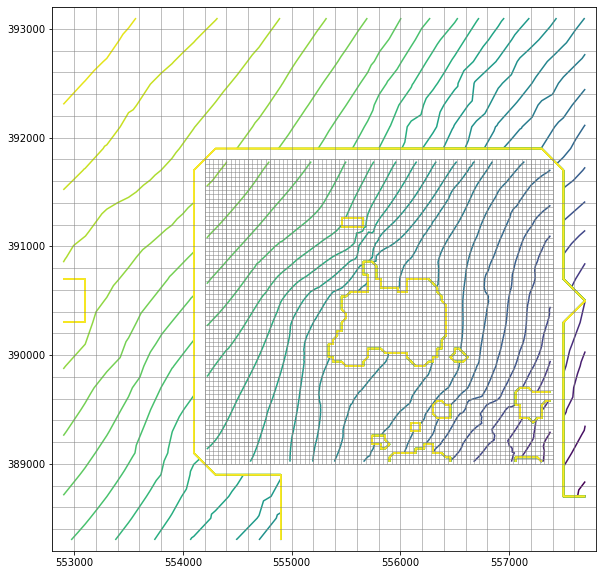

In [12]:
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

pctr = parent_mv.contour_array(lgr_parent_hds, levels=np.arange(290, 315))
ictr = inset_mv.contour_array(lgr_inset_hds, levels=np.arange(290, 315))
#qmp = parent_mv.plot_array(lgr_parent_hds)
#qmi = inset_mv.plot_array(lgr_inset_hds)

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
#plt.colorbar(qmp)

In [13]:
for model in m, inset:
    mfexport.export(model, model.modelgrid, output_path='postproc/{}/'.format(model.name))

creating postproc/plsnt_lgr_parent/pdfs...
creating postproc/plsnt_lgr_parent/shps...
creating postproc/plsnt_lgr_parent/rasters...

dis package...
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay4.tif
top:
wrote postproc/plsnt_lgr_parent/rasters/top.tif
botm:
wrote postproc/plsnt_lgr_parent/rasters/botm_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay4.tif
idomain:
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_

In [14]:
for model in m, inset:
    mfexport.summarize(model, output_path='postproc/{}/'.format(model.name))

summarizing plsnt_lgr_parent input...
summarizing plsnt_lgr_inset input...
skipped, not implemented yet


In [15]:
outpath='postproc/{}/shps'.format(inset.name)
if not os.path.isdir(outpath):
    os.makedirs(outpath)
connectiondata = pd.DataFrame(inset.lak.connectiondata.array)
k, i, j = cellids_to_kij(connectiondata['cellid'])
connectiondata['k'] = k
connectiondata['i'] = i
connectiondata['j'] = j
connectiondata.drop('cellid', axis=1, inplace=True)
polygons = np.reshape(inset.modelgrid.polygons, (inset.modelgrid.nrow, inset.modelgrid.ncol))
connectiondata['geometry'] = polygons[i, j]
df2shp(connectiondata, os.path.join(outpath, 'lake_connections.shp'), epsg=3070)

creating shapely Polygons of grid cells...
finished in 0.03s

writing postproc/plsnt_lgr_inset/shps/lake_connections.shp... Done
